In [ ]:
# !jt -t onedork -fs 100 -altp -tfs 14 -nfs 115 -T 
!jt -t onedork -fs 11 -ofs 10 -altp -tfs 14 -nfs 120 -cellw 70% -T

In [1]:
import cv2
import os
import glob
import math
import numpy as np
import pandas as pd
from tqdm import tqdm
import config
import matplotlib.pyplot as plt
# from cleaning_with_coordinate_clustering import VideoReader, Metadata

# face_coordinates = pd.read_json(config.FACE_COORDINATES_PATH).T

In [ ]:
%%timeit
import numpy as np
very_long_list = list(range(100000))
even = np.concatenate([[a] for a in very_long_list if a%2 == 0])
odd = np.concatenate([[a] for a in very_long_list if a%2 != 0])

In [ ]:
%%timeit
import numpy as np
very_long_list = list(range(100000))
evens = []
odds = []
for item in very_long_list:
    if item % 2 == 0:
        evens.append(item)
    else:
        odds.append(item)

# Face size check

In [ ]:
faces = glob.glob(config.TRAIN_IMAGES+'/*')
print(f"{len(faces)} faces were detected")

In [ ]:
widths, heights = [], []
small_imgs = []

for i, p in enumerate(faces):
    if i % 500 == 0: 
        print(i, end=' ')
    img = cv2.imread(p)
    h,w, _ = img.shape
    if w < 100 or h < 100:
        small_imgs.append(img)
    
    widths.append(w)
    heights.append(h)

In [ ]:
# os.mkdir('tmp-small-imgs')
for i, im in enumerate(small_imgs):
    cv2.imwrite(f'tmp-small-imgs/{i}.png', im)

In [ ]:
res = plt.hist(heights, bins=range(0,250,10), alpha=0.5)

for c, b in zip(*res[:2]):
    print(f'{b} : {c}')

In [ ]:
res = plt.hist(widths, bins=range(0,250,10), alpha=0.5)

for c, b in zip(*res[:2]):
    print(f'{b} : {c}')

In [ ]:
from facenet_pytorch import MTCNN
from PIL import Image

mtcnn = MTCNN(224)


In [ ]:
results = {}
problems = []
for i, p_img in enumerate(faces):
    if (i+1) % 100 == 0:
        print(i+1, end=' ')
    img = Image.open(p_img)
    
    try:
        cord, probs = mtcnn.detect(img)
        results[p_img] = {'cord': cord, 'probs': probs}
    except:
        problems.append(p_img)
        print(f'Problem with: {p_img}')
# img_cropped.save('tmp-small-imgs/5-2.png')

In [ ]:
counter = 0
for k,v in results.items():
    if v['cord'] is None:
        print(k)
        counter += 1
counter

In [ ]:
Image.open(r'D:/DFDC/train_images\chunk_8_38.png')

# Arranging labels for test images

In [ ]:
original_labels = pd.read_csv(f'{config.root}/videos_test/labels.csv')
imgs = os.listdir(f'{config.root}/test_images')

In [ ]:
original_labels

In [ ]:
new_labels = pd.DataFrame({ 'names': imgs })
new_labels['video_names'] = new_labels['names'].apply(lambda x: x.split('_')[0])
labels = new_labels.merge(original_labels, how='left', left_on='video_names', right_on='filename')
labels['labels'] = labels['label'].apply(lambda x: 'REAL' if x==0 else 'FAKE')
labels.drop(columns=['video_names', 'filename'], inplace=True)
labels

In [ ]:
labels.to_csv(f'{config.root}/test_labels.csv', index=False)

# Video based results

In [ ]:
import os
import config
import glob
import pandas as pd
from sklearn.metrics import log_loss

In [ ]:
def get_video_based_log_loss(df_path, targets='targets', predictions='confidence_1', save=False):
    results = pd.read_csv(df_path)
    results['video_names'] = results['paths'].apply(lambda x: os.path.basename(x).split('_')[0])
    df = results.groupby('video_names').mean().reset_index()
#     print(results)
    if save:
        df.to_csv(f'f{config.root}/test_results/video_based_{os.path.basename(df_path)}.csv', index=False)
    
    return round(log_loss(df[targets], df[predictions]), 4)

In [ ]:
old_data = glob.glob(f'{config.root}/test_results/DFDC-phase-5*.csv')

for p in old_data:
    print(f"{os.path.basename(p).split('-test')[1]} : {get_video_based_log_loss(p, predictions='confidence_0')}")

## Unchecked video analysis

In [ ]:
missing_videos = original_labels[original_labels['filename'].isin(set(original_labels['filename']) - set(df['video_names']))]
missing_videos = missing_videos.reset_index(drop=True).rename(columns={'label':'targets', 'filename':'video_names'})
missing_videos['confidence_0'] = 0.5
missing_videos['confidence_1'] = 0.5

In [ ]:
df = pd.concat([df, missing_videos])
df

# Face tracking

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from facenet_pytorch.models.mtcnn import MTCNN
from utils import get_frames
import iou
import config

In [ ]:
mtcnn = MTCNN(**config.FACE_DETECTOR_KWARGS)

video_path = f'{config.root}/videos_test/viaobrvusg.mp4'
frames = get_frames(video_path, start=0, step=1, output_type='PIL')

tmp_frame = frames[0]
new_width, new_height = tmp_frame.width // 2, tmp_frame.height//2

resized_frames = [frame.resize((new_width, new_height)) for frame in frames]
coordinates, probabilities = mtcnn.detect(resized_frames)

## IOU tracking

**Problems**
1. Trackable secondary face
2. Random face on top of original face
3. How to decide which face should be kept?
4. Main faces disapears for few frames

In [ ]:
face_id = 0
faces = {}


for frame_id, frame in enumerate(coordinates):
    last_faces = []
    last_face_ids = []
    
    for fid in range(face_id):
        last_face, prev_frame_id = faces[fid][-1]
        
        # lossing same face for 2 frames is ok
        if frame_id - prev_frame_id <= 2:
            last_faces.append(last_face)
            last_face_ids.append(fid)
    
    for c in frame:
        if len(last_faces) == 0:
            faces[face_id] = [(c, frame_id)]
            face_id += 1
            
        else:
            all_iou, iou_max, nmax = iou.get_max_iou(np.array(last_faces), c)
            if iou_max > 0.75:
                last_face_id = last_face_ids[nmax]
                faces[last_face_id].append((c, frame_id))
            else:
                faces[face_id] = [(c, frame_id)]
                face_id += 1    

In [ ]:
# legacy
face_id = 0
faces = {}

for frame in coordinates:
    
    last_faces = []
    last_face_ids = []
    unupdated_faces = list(range(face_id))
    
    # getting last face of each id
    for i in range(face_id):
        last_face = faces[i][-1]
        
        if last_face is not None:
            last_faces.append(last_face)
            last_face_ids.append(i)
            
    # checking most intersacted frame
    for c in frame:
        if len(last_faces) == 0:
            faces[face_id] = [c]
            face_id += 1
        else:
            all_iou, iou_max, nmax = iou.get_max_iou(np.array(last_faces), c)
            if iou_max > 0.75:
                faces[last_face_ids[nmax]].append(c)
                unupdated_faces.remove(nmax)
            else:
                faces[face_id] = [c]
                face_id += 1        
    for u in unupdated_faces:
        faces[u].append(None)

In [ ]:
for fid, coord in faces.items():
    df = pd.DataFrame({fid:faces[fid]})
    print(fid, len(df[df[fid].notna()]), end=' | ')
    break

## Calculating and drawing centers

In [ ]:
centers = []

for frame in coordinates:
    center = []
    for c in frame:
        centerx = (c[0] + c[2])/2
        centery = (c[1] + c[3])/2
        center.append([centerx, centery])
    centers.append(center)

In [ ]:
x_axis_data = []
x_coords = []
y_coords = []
for i, frame in enumerate(centers):
    for x,y in frame:
        x_axis_data.append(i)
        x_coords.append(x)
        y_coords.append(y)

In [ ]:
# x axis data per frame
plt.scatter(x_axis_data, x_coords)

In [ ]:
# y axis data per frame
plt.scatter(x_axis_data, y_coords)

In [ ]:
# heatmap
plt.scatter(x_coords, y_coords, s=5)

## Displaying detected faces

In [ ]:
# drawing rectangle
idx = 285
img = resized_frames[idx].copy()
draw = ImageDraw.Draw(img)
for c in coordinates[idx]:
    draw.rectangle(c, outline='red')
img

## Checking tracking performance

In [ ]:
import glob
import pickle
import numpy as np
import config

In [ ]:
video_name = 'aalscayrfi.mp4'
p_coord = f'{config.root}/tracked_videos/{video_name}.pkl'
with open(p_coord, 'rb') as fp:
    coords = pickle.load(fp)

In [ ]:
# performance check
all_data = glob.glob(f'{config.root}/tracked_videos/*.pkl')

stats = {
    'no_data': 0,
    '300': 0,
    '300+': 0,
    'average':0,
    '<100': 0,
    'double face+250': 0,
    '10+ faces': 0
}

for p in all_data:
    with open(p, 'rb') as fp:
        coords = pickle.load(fp)
        if len(coords) == 0:
            stats['no_data'] += 1
            continue
        else:
            size_of_values = [len(v) for k,v in coords.items()]
            if len(size_of_values) > 10:
                stats['10+ faces'] += 1
                
            max_value = max(size_of_values)
            if max_value > 300:
                stats['300+'] += 1
            elif max_value == 300:
                stats['300'] += 1
            elif 100 <= max_value < 250:
                stats['average'] += 1
            elif max_value < 100:
                stats['<100'] += 1
            elif max_value in range(95, 105):
                print(p)
                
            counter = 0
            for v in sorted(size_of_values, reverse=True):
                if v >= 50:
                    counter += 1
            if counter >= 5:
                print(p, counter)
            if counter >= 2:
                key = f'double face_{counter}'
                if key in stats:
                    stats[key] += 1
                else:
                    stats[key] = 1
            

In [ ]:
stats

# Video Player for test set

<AxesSubplot:>

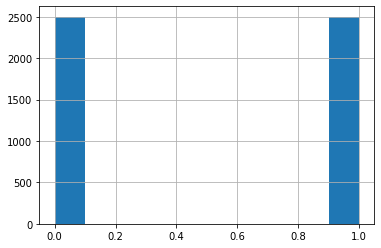

In [41]:
from IPython.display import Video
import config
import glob
import os
import pandas as pd
videos = glob.glob(f'{config.root}/videos_test/*.mp4')
labels = pd.read_csv(f'{config.root}/videos_test/labels.csv')
metadata = pd.read_json(f'{config.root}/videos_test/metadata.json').T

labels = labels.set_index('filename')
video_map = {os.path.basename(p): p for p in videos}
labels.label.hist()

In [ ]:
# zzoqoqsqtf.mp4 - very bad example, not includeds

In [ ]:
os.path.exidd

In [49]:
vid = videos.index(video_map['gocjpmgymw.mp4'])
name = os.path.basename(videos[vid])
print(name)
print(f'label: {labels.loc[name]["label"]}')
print(f'Metadata: {metadata.loc[name].to_list()}')
video_path = videos[vid]
Video(video_path, embed=True, width=960)

gocjpmgymw.mp4
label: 0
Metadata: [{'distractor': {'df_tricks': {'num_imgs': 2, 'random_imgs': False, 'random_movement': True}}}, 0]


# Getting saved checkpoints

In [6]:
import glob
import pathlib
from datetime import datetime

import config
models = glob.glob(f'{config.CHECKPOINT_PATH}/model*.ckpt')
start_date = datetime.strptime('15/05/21 18:00:00', '%d/%m/%y %H:%M:%S')

len(models)

148

In [7]:
def get_info(p):
    model_name, run_id = p.split('-')[:2]
    return model_name.split('=')[-1], run_id.split('=')[-1]

In [ ]:
# filter by creation date
for m in models:
    fname = pathlib.Path(m)
    mtime = datetime.fromtimestamp(fname.stat().st_mtime)
    
    if mtime >= start_date:
        model_name, run_id = get_info(fname.name)
        print(f"'{run_id}': ('{fname.name}', '{model_name}'),")


In [8]:
# filter by run id
# run_ids = {"14gmkyn5","2qzxw7hr","26lq8ukl","2jgg8o0p","3i7biy9f","3fi7o55r","1290cqno","3i6mxeqt","1mqztpfc","so3wfiee","wlstbcdy","2k8jf1oy","2u1txf0a","36m8051l","24p29awr","2udhb50w",}
run_ids = {"2u1txf0a","4jnbnk3u","djinh5d4","ay5l7q3q","c3x0rzgt","v2cq0a1n","np7d6t9p","6ihp9jw7"}

for m in models:
    fname = pathlib.Path(m)
    model_name, run_id = get_info(fname.name)
    if run_id in run_ids:
        print(f"'{run_id}': ('{fname.name}', '{model_name}'),")

'v2cq0a1n': ('model=densenet161-run_id=v2cq0a1n-epoch=01-val_loss=0.3785.ckpt', 'densenet161'),
'ay5l7q3q': ('model=inception_resnet_v2-run_id=ay5l7q3q-epoch=01-val_loss=0.4274.ckpt', 'inception_resnet_v2'),
'djinh5d4': ('model=inception_v4-run_id=djinh5d4-epoch=04-val_loss=0.4442.ckpt', 'inception_v4'),
'c3x0rzgt': ('model=tf_efficientnet_b0_ns-run_id=c3x0rzgt-epoch=03-val_loss=0.3987.ckpt', 'tf_efficientnet_b0_ns'),
'4jnbnk3u': ('model=xception-run_id=4jnbnk3u-epoch=01-val_loss=0.4701.ckpt', 'xception'),
'2u1txf0a': ('model=tf_efficientnet_b4_ns-run_id=2u1txf0a-epoch=02-val_loss=0.3715.ckpt', 'tf_efficientnet_b4_ns'),
'6ihp9jw7': ('model=mobilenetv3_large_100-run_id=6ihp9jw7-epoch=05-val_loss=0.4229.ckpt', 'mobilenetv3_large_100'),
'np7d6t9p': ('model=resnet50-run_id=np7d6t9p-epoch=04-val_loss=0.4705.ckpt', 'resnet50'),


# Reading wandb config with python

In [2]:
import torch
import yaml
from training.datasets import DFDCLightningDataset

Global seed set to 99


In [3]:
class Map(dict):
    """
    Example:
    m = Map({'first_name': 'Eduardo'}, last_name='Pool', age=24, sports=['Soccer'])
    """
    def __init__(self, *args, **kwargs):
        super(Map, self).__init__(*args, **kwargs)
        for arg in args:
            if isinstance(arg, dict):
                for k, v in arg.items():
                    self[k] = v

        if kwargs:
            for k, v in kwargs.items():
                self[k] = v

    def __getattr__(self, attr):
        return self.get(attr)

    def __setattr__(self, key, value):
        self.__setitem__(key, value)

    def __setitem__(self, key, value):
        super(Map, self).__setitem__(key, value)
        self.__dict__.update({key: value})

    def __delattr__(self, item):
        self.__delitem__(item)

    def __delitem__(self, key):
        super(Map, self).__delitem__(key)
        del self.__dict__[key]

In [4]:
def get_config():
    config = {}
    with open('training/config-defaults.yaml') as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
        
        for k, v in data.items():
            config[k] = v['value']
    
    return Map(config)

In [ ]:
d = {'detector': 'MTCNN',
 'sampling_rate': 30,
 'margin': 30,
 'thresholds_mtcnn': None,
 'min_face_size': 60,
 'image_size': 224,
 'batch_size': 64,
 'load_pretrained': True,
 'load_checkpoint': False,
 'use_chunks': False,
 'project': 'DFDC-test',
 'model_name': 'tf_efficientnet_b0_ns',
 'run_name': 'efnet-b0-ns-accumulate-grad8',
 'notes': 'increasing cut size to 32',
 'resume_from': None,
 'epochs': 5,
 'target_size': 2,
 'output_weights': None,
 'device': 'cuda',
 'gpus': 1,
 'precision': 16,
 'accumulate_grad_batches': 8,
 'limit_train_batches': 1.0,
 'opt_name': 'Adam',
 'lr_scheduler': 'step',
 'lr_min': 1e-05,
 'lr_max': 0.001,
 'lr_gamma': 0.5,
 'lr_mode': 'triangular2',
 'lr_step_size': 2,
 'lr_t0': 5,
 'lr_tmult': 1,
 'val_freq': 1,
 'log_freq': 10}
with open('result.yml', 'w') as yaml_file:
    yaml.dump(d, yaml_file, default_flow_style=False)

In [ ]:
dataset = DFDCLightningDataset(get_config())
dataset.prepare_data()
loader = dataset.train_dataloader()

# Testing pretrained model

In [ ]:
import wandb
from pytorch_lightning import Trainer

from training.datasets import DFDCLightningDataset
from training.model_zoo import DFDCModels
import local_properties
import config
import os
os.environ['REQUESTS_CA_BUNDLE'] = local_properties.SSL_CERTIFICATE_PATH

In [ ]:
# model.load_state_dict(checkpoint['state_dict'])
params = get_config()
dataset = DFDCLightningDataset(params)
model = DFDCModels(params)

runs = {
   "1llb9qpj": "tf_efficientnet_b0_ns-1llb9qpj-epoch=03-val_loss=0.0168.ckpt",
    "5qis6ixz": "efb0-ns-epoch=02-val_loss=0.0237.ckpt",
    "b9nqa6xq":"efb0-v1-epoch=03-val_loss=0.0115.ckpt"
}

trainer = Trainer(
    gpus = params.gpus,
    precision = params.precision,
    max_epochs=0
)
# wandb.finish()

In [ ]:
fitted = False

for run_id, ckpt_name in runs.items():
    wandb.init(id = run_id)
    if not fitted:
        trainer.fit(model, dataset)
    p = os.path.join(config.CHECKPOINT_PATH, ckpt_name)
    print(f"{p} : {os.path.exists(p)}")
    trainer.test(ckpt_path = p)
    wandb.finish()
    fitted = True

In [ ]:
trainer.test(ckpt_path='D:/DFDC/checkpoints/tf_efficientnet_b0_ns-1llb9qpj-epoch=03-val_loss=0.0168.ckpt')

In [ ]:
model.to('cuda')
model.freeze()
model.eval()

# Loading pre-trained model v2

In [ ]:
import os
import sys
from training.model_zoo import DFDCModels

os.chdir('training')

In [ ]:
from pytorch_lightning.loggers import WandbLogger
def headlines():
    with open('config-defaults.yaml') as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
        return data['project']['value'], data['run_name']['value']
project, name = headlines()
wandb_logger = WandbLogger(project=project, name=name, mode='offline')
config = wandb_logger.experiment.config

In [ ]:
if config.load_checkpoint:
    print(config.load_checkpoint)

In [ ]:
model = DFDCModels(config)

In [ ]:
import torch
checkpoint = torch.load('D:/DFDC/checkpoints/efb0-ns-epoch=02-val_loss=0.0237.ckpt')
model.load_state_dict(checkpoint['state_dict'])

In [ ]:
checkpoint.keys()

In [ ]:
model.to('cuda')
model.freeze()
model.eval()

In [ ]:
from datasets import DFDCDatasetImages
from PIL import Image

In [ ]:
images, labels, file_paths = [],[],[]

In [ ]:
test_data = DFDCDatasetImages(data='test', mode='valid')
image, label, file_path = test_data[4356]
images.append(image)
labels.append(label)
file_paths.append(file_path)

In [ ]:
im = Image.open(file_paths[3])
im

In [ ]:
model(torch.unsqueeze(image.to('cuda'), 0))

In [ ]:
logits_sig = torch.sigmoid(model(torch.unsqueeze(image.to('cuda'), 0)))
logits_sig, torch.argmax(logits_sig, dim=1)

In [ ]:
0.9821 + 0.0192, 9.9964e-01 + 3.5716e-04

In [ ]:
logits_soft = torch.nn.functional.softmax(model(torch.unsqueeze(image.to('cuda'), 0)))
logits_soft, torch.argmax(logits_soft, dim=1)

# Messing around with metrics

In [ ]:
import torch
from torchmetrics.functional import accuracy, precision_recall_curve, precision, recall
from torchmetrics import Accuracy, Precision, Recall, MetricCollection

In [ ]:
metric = MetricCollection([Accuracy(), Precision(), Recall()])

In [ ]:
target = torch.tensor([[0.3, -0.1], [0.51, 0.49]])
preds = torch.tensor([0, 1, 0, 0])

# metric(preds, target)

In [ ]:
confidence = torch.softmax(target.to('cuda'), 1)
confidence

In [ ]:
torch.max(confidence, dim=1).values.cpu().numpy()

In [ ]:
for img, label in loader:
    y_hat1 = model(img.to('cuda'))
    y_sigm = torch.sigmoid(y_hat1.squeeze())
    y_hat = torch.argmax(y_sigm, dim=1)
    print(metric(y_hat.cpu(), label))
    break

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
confusion_matrix(label, y_hat.cpu())

In [ ]:
for c in [0,1]:
    print(c)
    for f in [f1_score, recall_score, precision_score]:
            print(f'{f.__name__} : {f(label, y_hat.cpu(), pos_label=c):.4f}')
    print('-'*65)
print(f"Accuracy: {accuracy_score(label, y_hat.cpu()):.4f}")

In [ ]:
print(classification_report(label, y_hat))

# Some stuff about face coordinates

In [ ]:
all_coordinate_files = glob.glob(os.path.dirname(config.FACE_COORDINATES_PATH) +'/*.json')

In [ ]:
# no face detected
total = 0
for file in all_coordinate_files:
    face_coordinates = pd.read_json(file).T
    no_face_videos = face_coordinates[face_coordinates.isnull().all(1)==True]
    if len(no_face_videos) > 0:
        print(os.path.basename(file), no_face_videos.index.to_list())
        total+=len(no_face_videos)
print(f'Total is {total}')

In [ ]:
len(all_coordinate_files)

In [ ]:
total = 0
total_video_count = 0
part_counter = 0

for file in all_coordinate_files:
    part_counter += 1
    face_coordinates = pd.read_json(file).T
    
    total_video_count += len(face_coordinates)
    all_face = face_coordinates[face_coordinates.notna().sum(1) > 10]
    if len(all_face) > 0:
        total += len(all_face)
print(total)

In [ ]:
336*128

In [ ]:
1386+701

In [ ]:
face_coordinates[face_coordinates.notna().sum(1) < 9]

In [ ]:
def display_images(images, cols = 5, titles=None, figsize=(64, 16)):
    plt.figure(figsize=figsize)
    rows = len(images) // cols + 1
    
    if titles is None:
        titles = ['']*len(images)
    
    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(rows, cols, i + 1)
        plt.title(title)
        plt.imshow(img)     
        
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
        plt.tick_params(
        axis='y',          # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        labelleft=False) # labels along the bottom edge are off

In [ ]:
video_names = glob.glob(config.VIDEO_PATH)

In [ ]:
from facenet_pytorch.models.mtcnn import MTCNN

mtcnn = MTCNN(**config.FACE_DETECTOR_KWARGS)

In [ ]:
for i,v in enumerate(video_names):
    if 'ulubxioaxe.mp4' == os.path.basename(v):
        print(i)
        break

In [ ]:
video = VideoReader('vninpbciju.mp4', face_coordinates)
faces, labels = video.extract_faces_v2()

In [ ]:
import cv2

cap = cv2.VideoCapture(video.path)
cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
video.path

In [ ]:
display_images(faces)

In [ ]:
from IPython.display import Video
Video(video.path, embed=True, width=640)

In [ ]:
res = mtcnn.detect(frames)

In [ ]:
boxes, preds = res

for b, p in zip(boxes, preds):
    print(b,p)

In [ ]:
frames[0].crop(boxes[0][-1])

In [ ]:
new_boxes, new_preds = [], []

for b, p in zip(boxes, preds):
    new_boxes.append(b[:2].tolist())
    new_preds.append(p[:2].tolist())

for b, p in zip(new_boxes, new_preds):
    print(b,p)

In [ ]:
for i, (id, row) in enumerate(face_coordinates.iterrows()):
    for j, r in enumerate(row):
        if r is not None and type(r) == list:
            if len(r) > 2:
                print(i, j, id, len(r))
        